# Using MobileNet for Transfer Learning to Classify Brawlhalla Legends (Adding a gradcam to it)
as the title says, idea is to get mobilenet model, and retrain is with my own data, in this case the brawlhalla-legend-dataset

i did use some code from the following sources
- https://stackoverflow.com/questions/66911470/how-to-apply-grad-cam-on-my-trained-model
- max's notebook
- chatgpt

### Import Dependencies

In [2]:
import numpy as np
import cv2
import PIL
import tensorflow as tf
import tensorflow_hub as hub
import sklearn as sk  # 1.3.1
import PIL.Image as Image
import sys
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import random
import copy
import math
import random

from IPython.display import Image as Image2, display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from pathlib import Path

print(sk.__version__)   # 1.3.1
print(np.__version__)   # 1.24.3
print(cv2.__version__)  # 4.8.1
print(PIL.__version__)  # 10.1.0
print(tf.__version__)   # 2.13.0
print(hub.__version__)  # 0.15.0
print(sys.version[0:7]) # 3.10.12

1.3.1
1.24.3
4.8.1
10.1.0
2.13.0
0.15.0
3.10.12


### Load Model

In [78]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [79]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False, input_shape=IMAGE_SHAPE+(3,), classes=4)
classifier.trainable = False

# classifier = tf.keras.Sequential([
#     hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
# ])

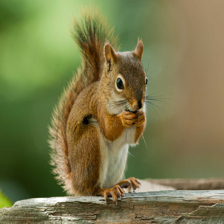

In [80]:
squirrel_image = Image.open('datasets/skquirrel.jpg').resize(IMAGE_SHAPE)
squirrel_image

Test model to see if its working

In [6]:
squirrel_image = np.array(squirrel_image)/255.0
squirrel_image[np.newaxis, ...].shape
result = classifier.predict(squirrel_image[np.newaxis, ...])
predicted_label_index = np.argmax(result)
with open("datasets/ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()

# image_labels[predicted_label_index]

1/1 [==============================] - 1s 738ms/step


## Now that we have the model loaded and working, we just need to load in the dataset and modify the model

# Load Dataset
All code is copy pasted from an earlier notebook 

In [7]:
ROOT_DIR = 'brawlhalla-data-legends/'


def get_sub_dirs(root_dir):
    classes = []
    for root_dir, dirs, files in os.walk(root_dir):
        if len(dirs) > 0:
            classes = dirs
    return classes


classes = get_sub_dirs(ROOT_DIR)
print(f'classes found {len(classes)}:')
for c in classes:
    print(c)

classes found 4:
0-bodvar
1-cassidy
2-lord-Vraxx
3-orion


In [8]:
# Variables
SIZE = 224
CLASS_NAMES = get_sub_dirs(ROOT_DIR)

# hardcoded
# Zero's represent images per legend (following legend order in game) -> Bodvar, Cassidy, Orion, Vraxx
legend_images = [0, 0, 0, 0]

# Functions

# there should be a way to remove the hardcoding here


def count_images_per_class(folder_name):
    if CLASS_NAMES[0] in str(folder_name):
        legend_images[0] += 1
    if CLASS_NAMES[1] in str(folder_name):
        legend_images[1] += 1
    if CLASS_NAMES[2] in str(folder_name):
        legend_images[2] += 1
    if CLASS_NAMES[3] in str(folder_name):
        legend_images[3] += 1


def load_image(file, SIZE):
    img = Image.open(file)
    img = img.resize((SIZE, SIZE))
    return np.array(img).flatten()


def load_labelled_images(path, SIZE):
    labels = list()
    files = list()
    for file_info in [x for x in Path(path).glob("**/*.jpg")]:
        labels.append(int(file_info.parts[1][0:1]))
        files.append(str(file_info))
        count_images_per_class(file_info)

    imgs = np.array([load_image(f, SIZE) for f in files])
    return imgs, np.array(labels)


# Load all images to the notebook
images, labels = load_labelled_images(ROOT_DIR, SIZE)
print("Loaded", len(images), "images in the following",
      len(np.unique(labels)), "classes:")

for label, image in zip(np.unique(labels), legend_images):
    print(f'{label} ({image})')

Loaded 146 images in the following 4 classes:
0 (31)
1 (44)
2 (39)
3 (32)


# Reshaping my dataset

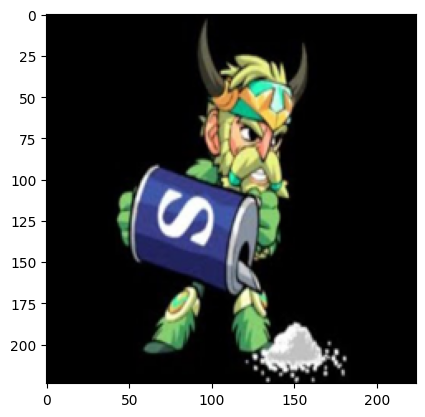

In [9]:
images = images.reshape(len(images), SIZE, SIZE, 3)
plt.imshow(images[0])

# Sampling Data

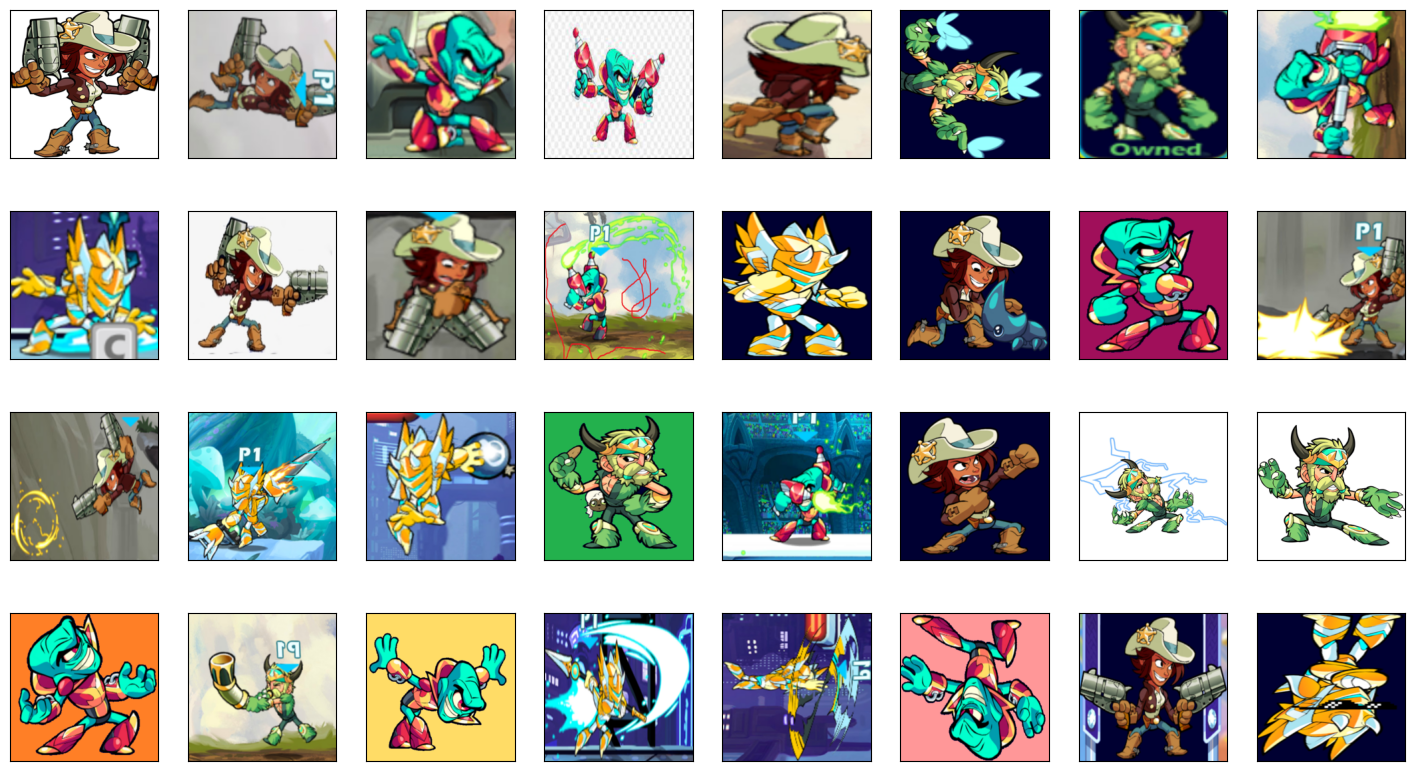

In [10]:
sample_size = 32

plotimgs = copy.deepcopy(images)
np.random.shuffle(plotimgs)
rows = plotimgs[:sample_size]

_, subplots = plt.subplots(nrows=math.ceil(
    sample_size/8), ncols=8, figsize=(18, int(sample_size/3)))
subplots = subplots.flatten()
for i, x in enumerate(rows):
    subplots[i].imshow(np.reshape(x, [SIZE, SIZE, 3]))
    subplots[i].set_xticks([])
    subplots[i].set_yticks([])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=.2)

# X_train
y_test

array([2, 2, 3, 1, 1, 3, 3, 0, 0, 1, 2, 2, 0, 2, 1, 1, 3, 3, 0, 3, 2, 2,
       1, 3, 3, 0, 1, 0, 1, 0])

In [12]:
X_train.shape

(116, 224, 224, 3)

# Modify the MobileNet model

In [81]:
num_of_legends = 4

output = classifier.output
output = tf.keras.layers.GlobalAveragePooling2D()(output)
output = tf.keras.layers.Dense(num_of_legends, activation='softmax')(output)

model = tf.keras.models.Model(inputs=classifier.input, outputs=output)
model.summary()

Model: "model_199"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             


                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']            
                                                                                                  
 expanded_conv_depthwise (D  (None, 112, 112, 32)         288       ['Conv1_relu[0][0]']          
 epthwiseConv2D)                                                                                  
                                                                                                  
 expanded_conv_depthwise_BN  (None, 112, 112, 32)         128       ['expanded_conv_depthwise[0][0
  (BatchNo

# Retrain on my own data

In [82]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'])

model.fit(X_train, y_train, epochs=50)

Epoch 1/50


c:\Users\kaan-\anaconda3\envs\tf213\lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4/4 [==============================] - 5s 449ms/step - loss: 2.0206 - acc: 0.2845
Epoch 2/50
4/4 [==============================] - 2s 448ms/step - loss: 1.4449 - acc: 0.3534
Epoch 3/50
4/4 [==============================] - 2s 465ms/step - loss: 1.3878 - acc: 0.3793
Epoch 4/50
4/4 [==============================] - 2s 454ms/step - loss: 1.2270 - acc: 0.5172
Epoch 5/50
4/4 [==============================] - 2s 446ms/step - loss: 1.0611 - acc: 0.5862
Epoch 6/50
4/4 [==============================] - 2s 468ms/step - loss: 0.9916 - acc: 0.5345
Epoch 7/50
4/4 [==============================] - 2s 461ms/step - loss: 0.9095 - acc: 0.6293
Epoch 8/50
4/4 [==============================] - 2s 489ms/step - loss: 0.8182 - acc: 0.7845
Epoch 9/50
4/4 [==============================] - 2s 461ms/step - loss: 0.7596 - acc: 0.8103
Epoch 10/50
4/4 [==============================] - 2s 458ms/step - loss: 0.7105 - acc: 0.8448
Epoch 11/50
4/4 [==============================] - 2s 472ms/step - loss: 0.6567 

# Load ealier trained model


In [85]:
# model = tf.keras.models.load_model('./model-50/')
# model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [86]:
model.evaluate(X_test, y_test)

c:\Users\kaan-\anaconda3\envs\tf213\lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/1 [==============================] - 2s 2s/step - loss: 0.6842 - acc: 0.7333


[0.6841719150543213, 0.7333333492279053]

## Evaulate Prediction

1/1 [==============================] - 2s 2s/step


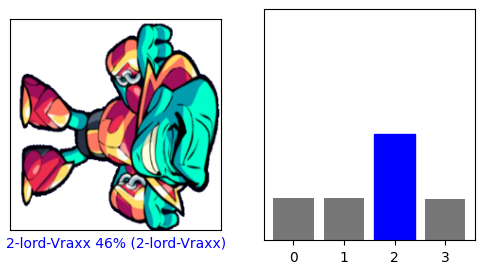

In [87]:
from modules.plot2 import plot_image, plot_value_array

probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(X_test)

i = 0
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, predictions[i], y_test, X_test, CLASS_NAMES)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions[i],  y_test)
plt.show()

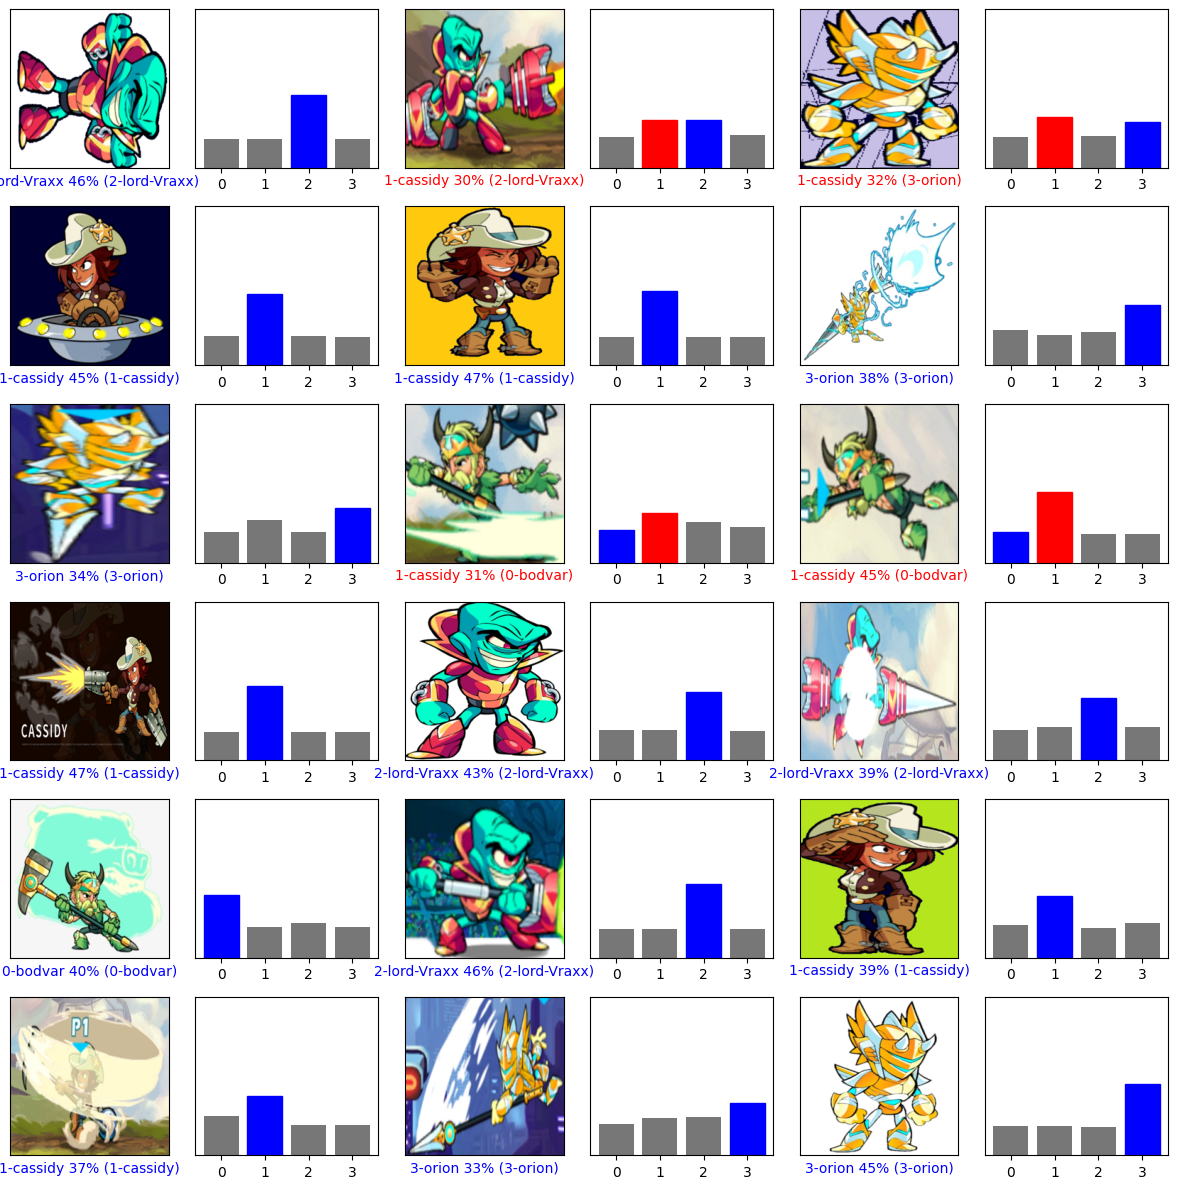

In [29]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 6
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, X_test, CLASS_NAMES)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

# XAI Section

In [34]:
brawl_legends = {
    "Bodvar": 0,
    "Cassidy": 1,
    "Orion": 2,
    "Lord-Vraxx": 3,
}

# Results (50 Epochs)

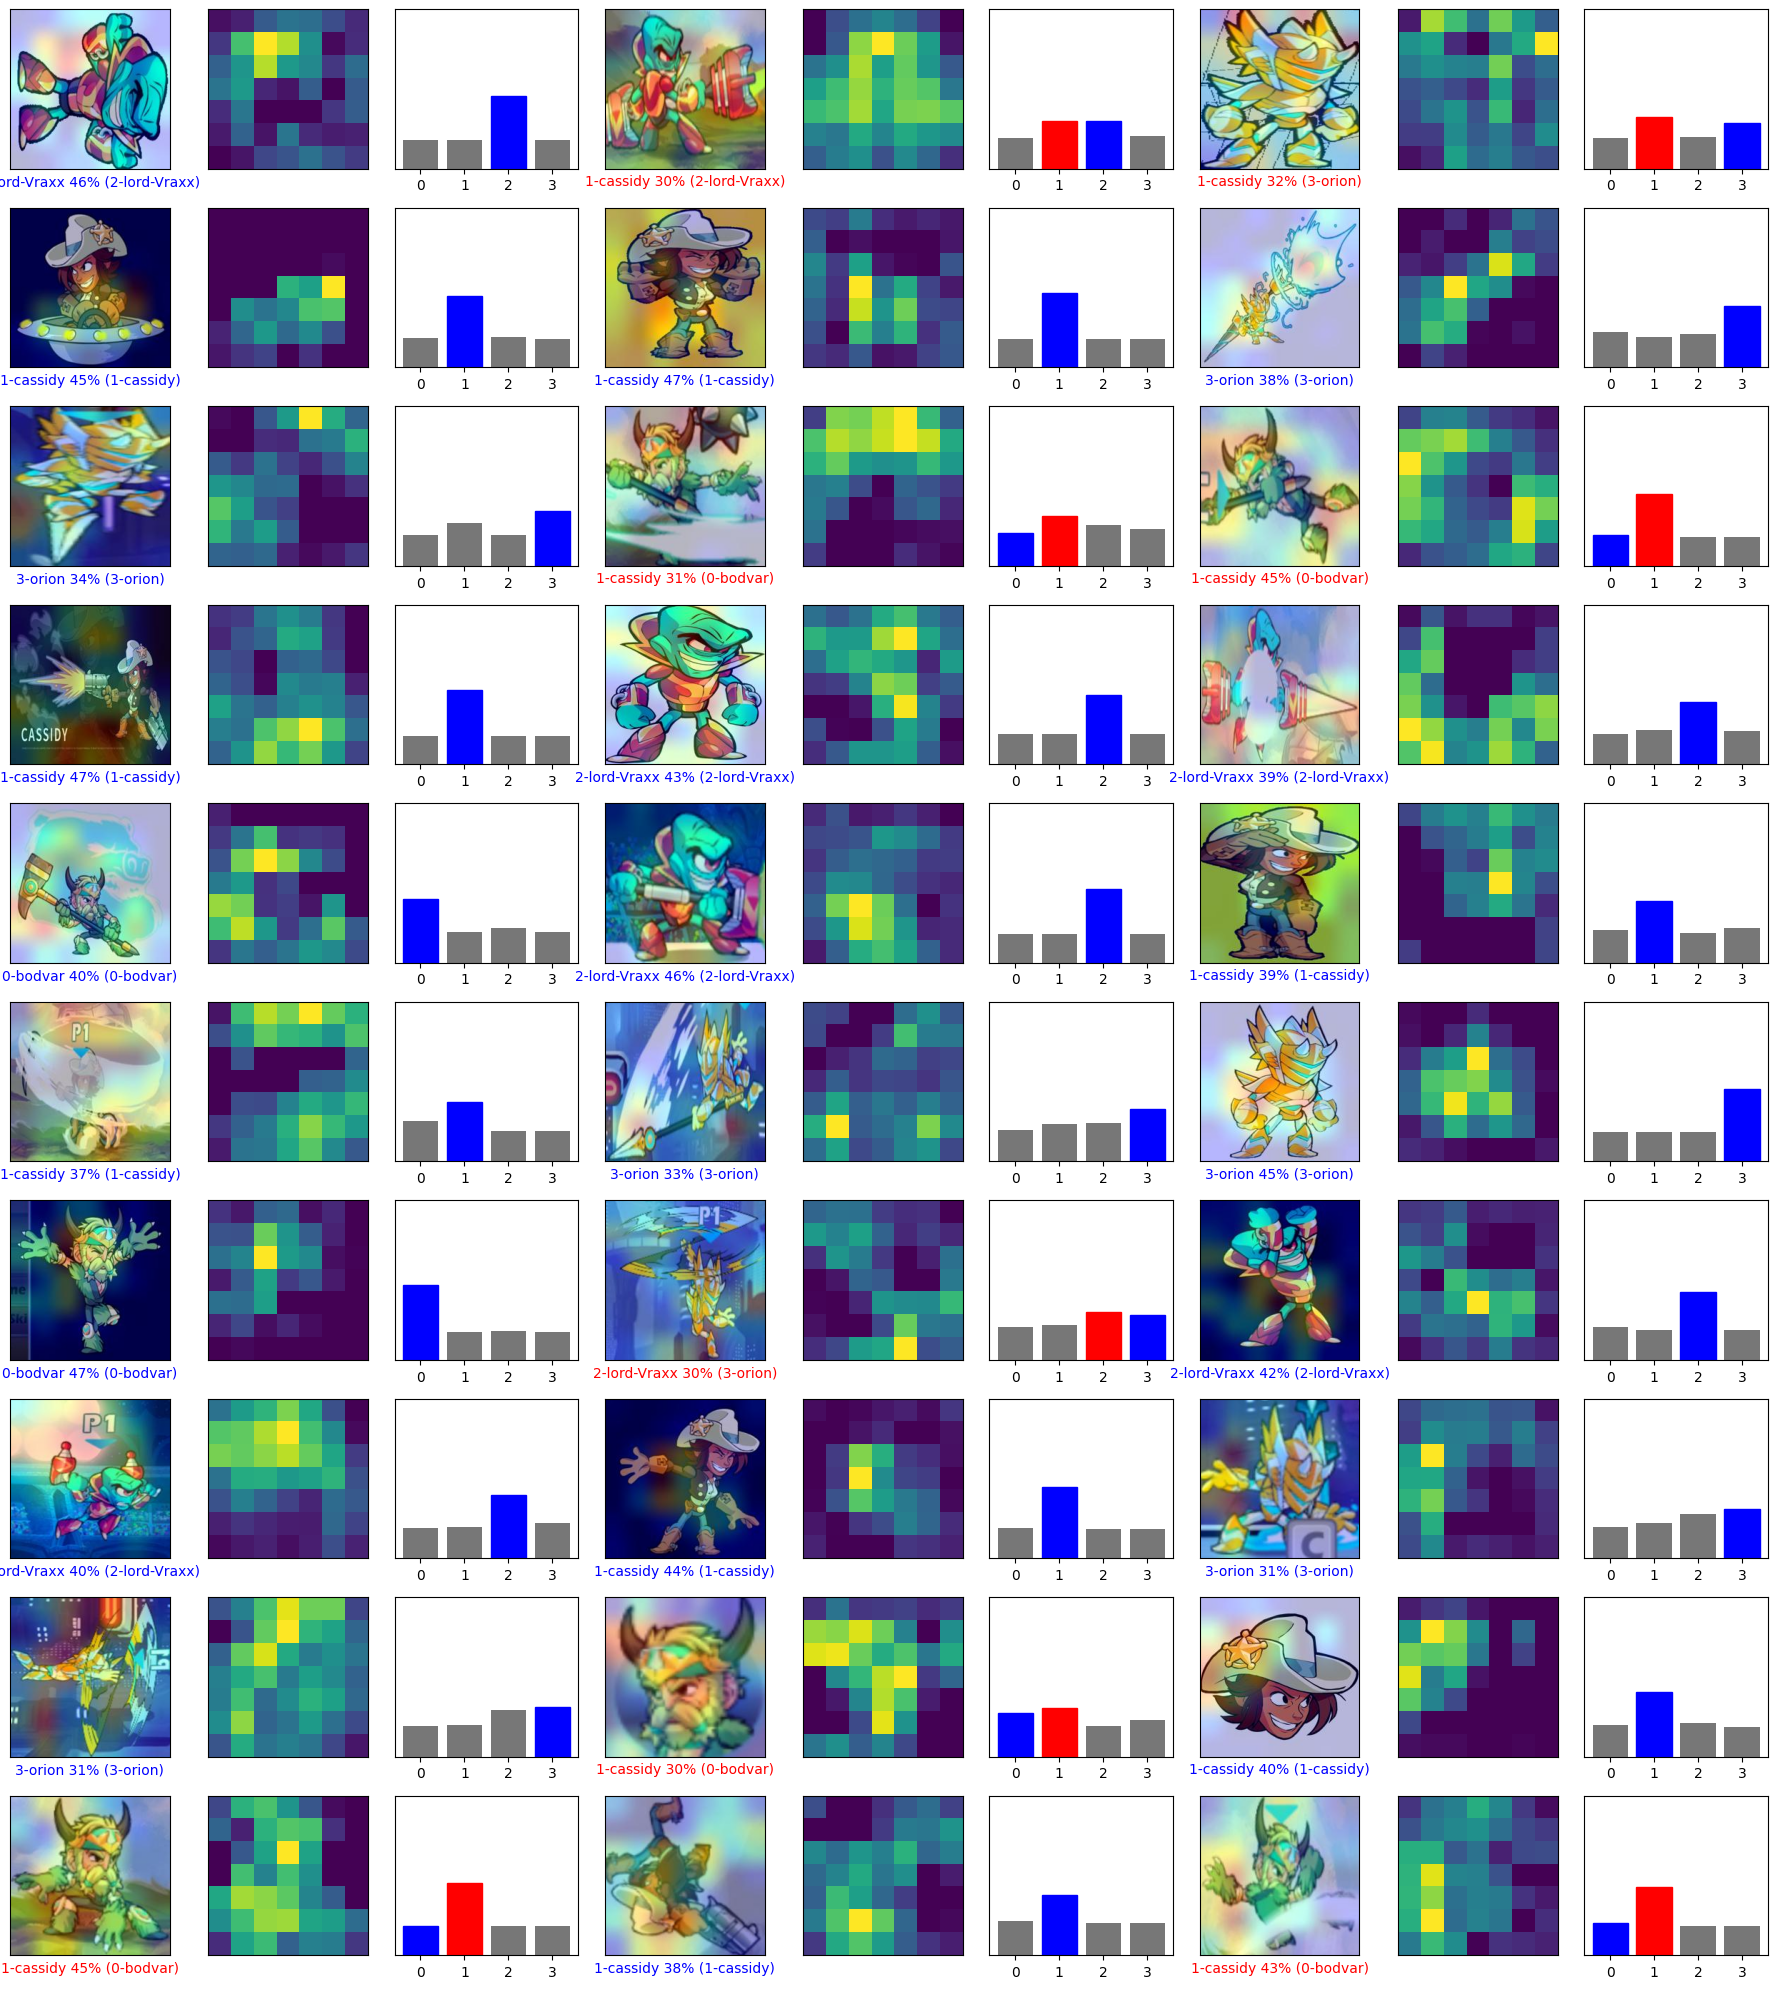

In [89]:
from io import BytesIO
from modules.plot2 import plot_image2, plot_heatmap8
from modules.gradcam2 import save_and_display_gradcam2, make_gradcam_heatmap
from modules.image_loading2 import get_img_array_via_image

last_conv_layer_name = "out_relu"
num_rows = 10
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*3*num_cols, 2*num_rows))
model.layers[-1].activation = None  # Remove last layer's softmax
for i in range(num_images):

  # Print what the top predicted class is
  legend = np.argmax(predictions[i])

  # Generate class activation heatmap
  img_array = get_img_array_via_image(X_test[i], img_size)
  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

  # Display heatmap over image
  gradcam_img = save_and_display_gradcam2(X_test[i], heatmap)
  img_data = BytesIO(gradcam_img.data)
  pil_image = Image.open(img_data)

  # Plot it
  plt.subplot(num_rows, 3*num_cols, 3*i+1)
  plot_image2(i, predictions[i], y_test, pil_image, CLASS_NAMES)  # image
  plt.subplot(num_rows, 3*num_cols, 3*i+2)
  plot_heatmap8(heatmap)
  plt.subplot(num_rows, 3*num_cols, 3*i+3)
  plot_value_array(i, predictions[i], y_test) 

plt.tight_layout()
plt.show()

# Conclusions (50 epochs)

#### Lord Vraxx
on lord vraxx it tries to look for the red-gold ish things in the image. for example his red-gold boots or red-gold rocket-lance.

vrax boot

<image src='lvboot.png'>

#### Orion
I feel like it tries to look for yellow body parts

if we look at the following image after what i just explained. we can understand why my model thinks this legend looks a lot like both orion and lord vrax, since it only looks at the boot which is yellowish but resembles the design of lord vrax's boot.

<image src='./explain.png'>

I cant explain whats going on in its mind for **bodvar** and **cassidy**